In [1]:
import os
import cv2
import copy
import itertools
import numpy as np

print("OpenCV " + cv2.__version__)

OpenCV 4.6.0


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 10] # figure size in inches

def draw_images(imgs):
    if len(imgs) > 1:
        fig, axs = plt.subplots(1, len(imgs))
        for idx, img in enumerate(imgs):
            axs[idx].axis("off")
            axs[idx].imshow(img)
    else:
        fig, ax = plt.subplots()
        ax.axis("off")
        ax.imshow(imgs[0])
    plt.show()

In [3]:
filenames = ["images/1.png", "images/2.png", "images/3.png", "images/4.png", "images/5.png"]

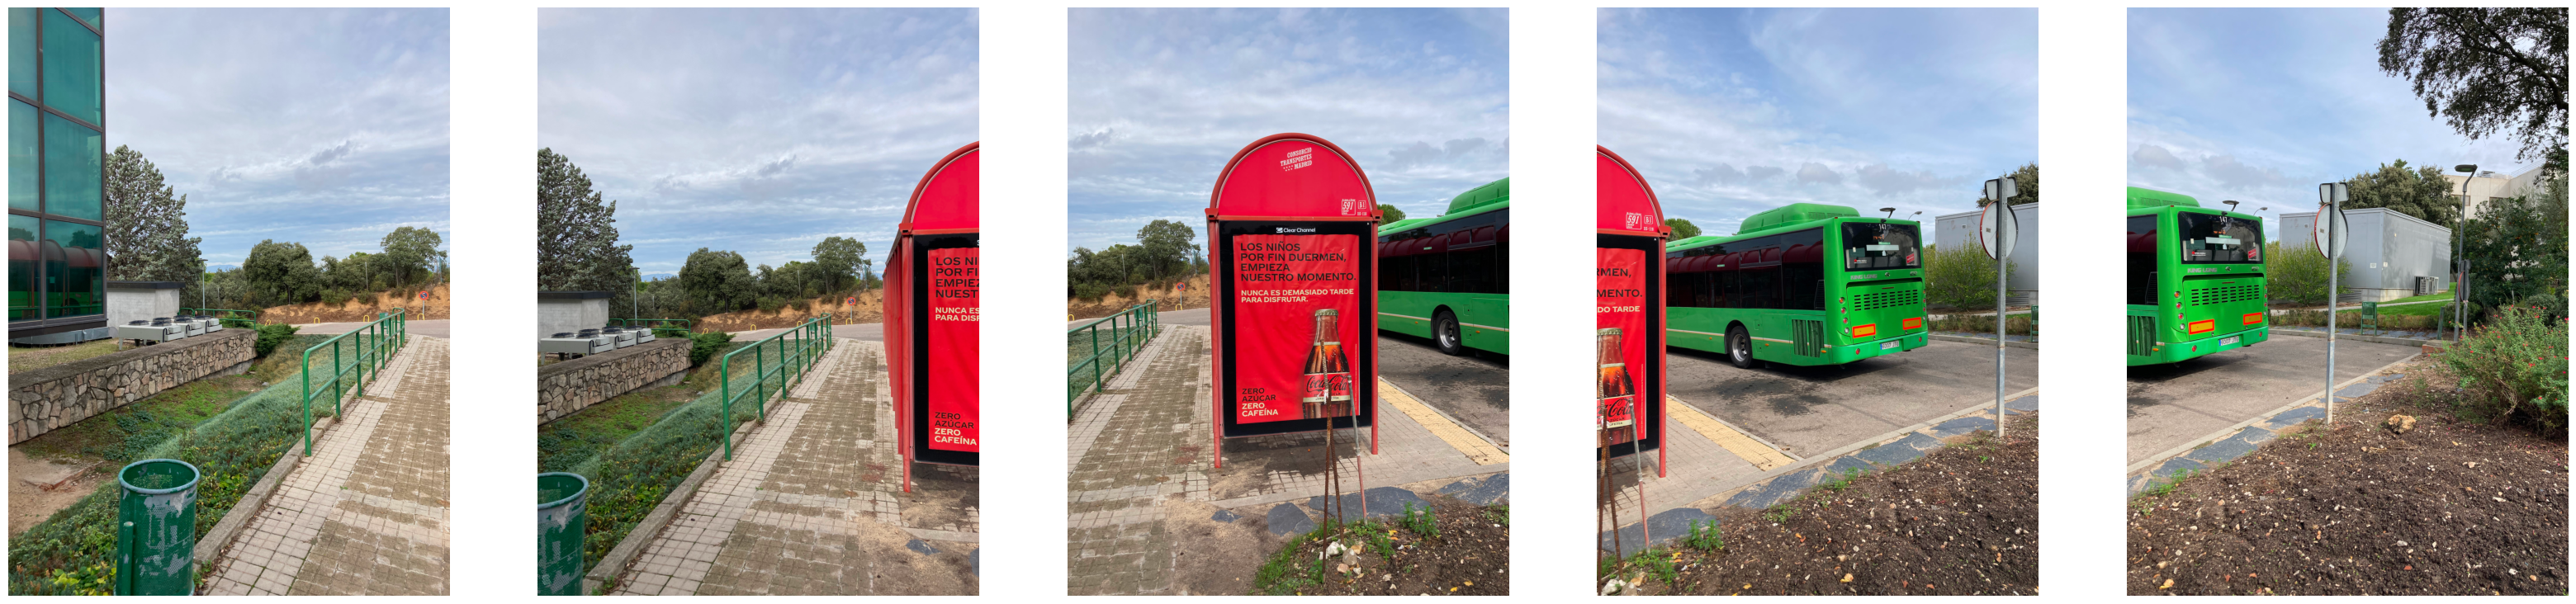

In [4]:
#Transform the images to RGB
imgs = [cv2.cvtColor(cv2.imread(filenames[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(filenames[1]), cv2.COLOR_BGR2RGB),  cv2.cvtColor(cv2.imread(filenames[2]), cv2.COLOR_BGR2RGB),  cv2.cvtColor(cv2.imread(filenames[3]), cv2.COLOR_BGR2RGB),  cv2.cvtColor(cv2.imread(filenames[4]), cv2.COLOR_BGR2RGB)]
#draw images
draw_images(imgs)

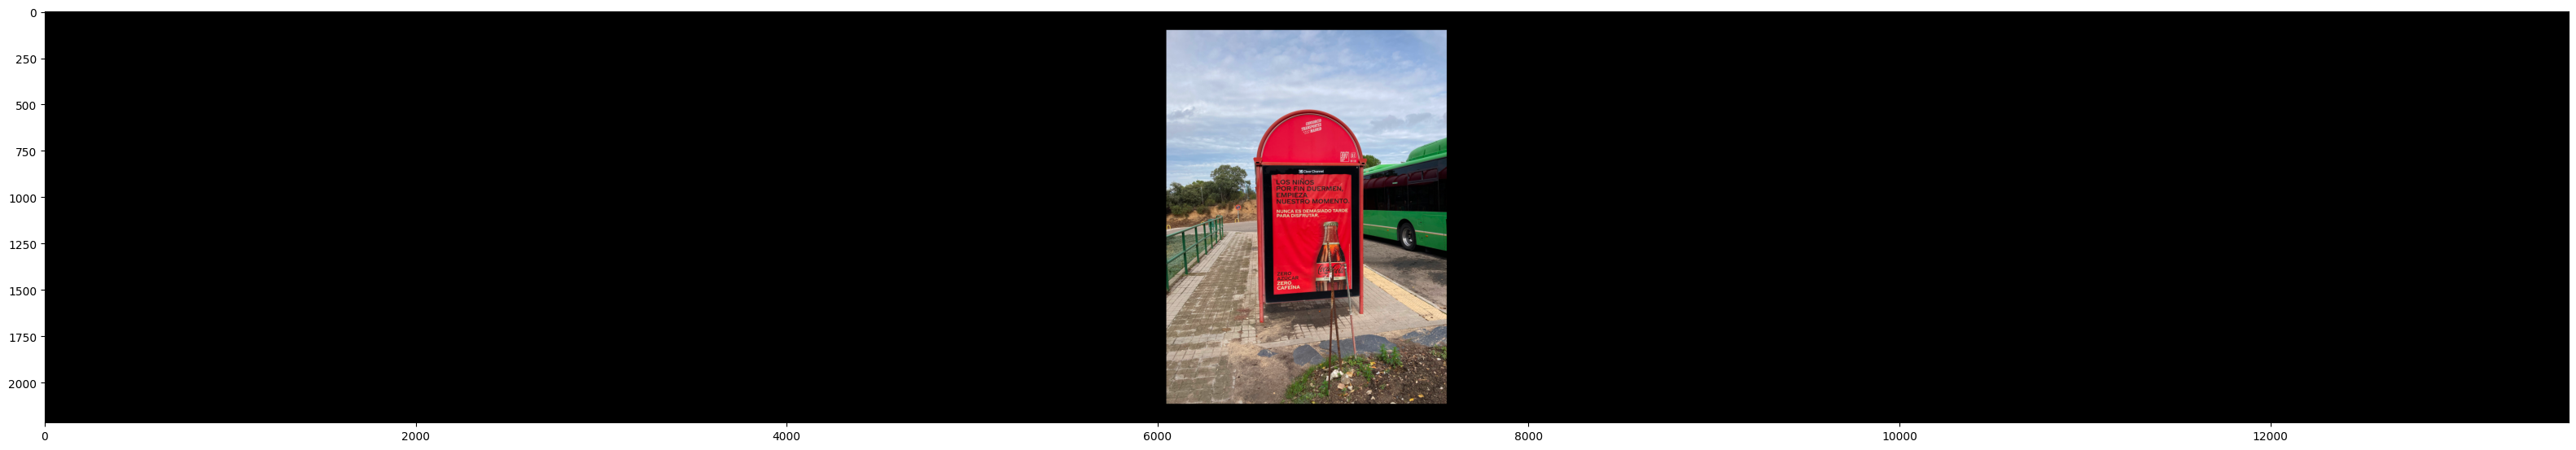

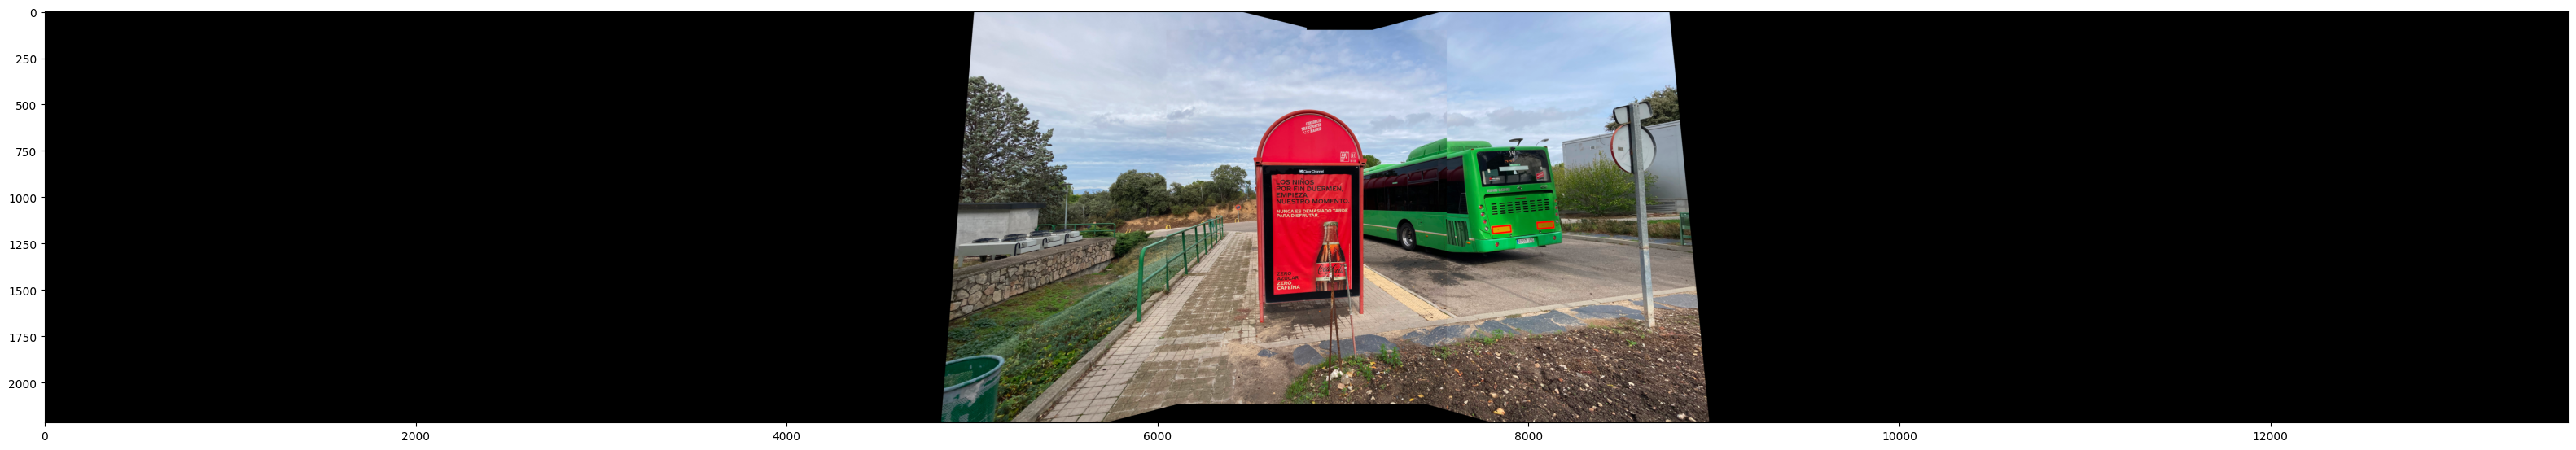

In [ ]:
#create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

#create BFMatcher object
match = cv2.BFMatcher()

#convert the images from RGB to GRAY
imgs_gray = [cv2.cvtColor(imgs[0], cv2.COLOR_RGB2GRAY), cv2.cvtColor(imgs[1], cv2.COLOR_RGB2GRAY), cv2.cvtColor(imgs[2], cv2.COLOR_RGB2GRAY), cv2.cvtColor(imgs[3], cv2.COLOR_RGB2GRAY), cv2.cvtColor(imgs[4], cv2.COLOR_RGB2GRAY)]

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(imgs_gray[0],None)
kp2, des2 = sift.detectAndCompute(imgs_gray[1],None)
kp4, des4 = sift.detectAndCompute(imgs_gray[3],None)
kp5, des5 = sift.detectAndCompute(imgs_gray[4],None)

#define panorama frame sizes
outer_x= imgs[2].shape[1]*9
outer_y= imgs[2].shape[0] + 200

#create panorama frame
frame = np.zeros([outer_y, outer_x, 3], np.uint8)
#put image 3 in the middle of the frame
frame[100:imgs[2].shape[0] + 100, imgs[2].shape[1]*4-1:imgs[2].shape[1]*5-1] = imgs[2]
#show the frame with image 3 in the center
plt.imshow(frame)
plt.show()

#---STITCH IMAGES 2 AND 4 IN REFERENCE IMAGE---
img2 = imgs[1] #image 2 in RGB
img3 = frame   #reference image in the frame in RGB (image 3)
img4 = imgs[3] #image 4 in RGB

img2_gray = imgs_gray[1] #image 2 in gray
img3_gray = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY) #reference image in frame in gray
img4_gray = imgs_gray[3] #image 4 in gray

#keypoints and descriptor of reference image (with SIFT)
keypoints, descriptor = sift.detectAndCompute(img3_gray,None) 
#list with the matches from image 2 to image 3 and from image 4 to image 3 (with BFMatcher)
matches = [match.knnMatch(des2, descriptor, k=2), match.knnMatch(des4, descriptor, k=2)] 

good2_3 = [] #list to store good matched from image 2 to image 3
good4_3 = [] #list to store good matches from image 4 to image 3
good = [good2_3, good4_3]

#find and store the good matches
for i in range(len(good)):
    for m,n in matches[i]:
        if m.distance < 0.8*n.distance:
            good[i].append(m)

#if number of mathces is higher than 10
if len(good2_3) > 10: 
    #define source and destination keypoints 
    src_pts = np.float32([ kp2[m.queryIdx].pt for m in good2_3 ]) #source points belong to image 2
    dst_pts = np.float32([ keypoints[m.trainIdx].pt for m in good2_3 ]) #destination points belong to image 3
    
    #find the homography matrix M2_3
    M2_3, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    print("Not enough matches are found.")
    
#if number of mathces is higher than 10
if len(good4_3) > 10: 
    #define source and destination keypoints 
    src_pts = np.float32([ kp4[m.queryIdx].pt for m in good4_3 ]) #source points belong to image 4
    dst_pts = np.float32([ keypoints[m.trainIdx].pt for m in good4_3 ]) #destination points belong to image 3
    
    #find the homography matrix M4_3
    M4_3, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    print("Not enough matches are found.")

    
#transform image 2 to stitch it to image 3
transform2 = cv2.warpPerspective(imgs[1], M2_3, (outer_x, outer_y)) 
#plt.imshow(transform2)
#plt.show()

#transform image 4 to stitch it to image 3
transform4 = cv2.warpPerspective(imgs[3], M4_3, (outer_x, outer_y)) 
#plt.imshow(transform4)
#plt.show()

#put transform4 on the right half of transform2
transform2[:, 6804:transform2.shape[1]-1] = transform4[:, 6804:transform4.shape[1]-1] 
#put image 3 in the center of transform2
transform2[100:imgs[2].shape[0]+100, imgs[2].shape[1]*4-1:imgs[2].shape[1]*5-1] = imgs[2] 

#show images 2,3,4 stitched together
panorama = transform2
plt.imshow(panorama)
plt.show()


#---STITCH IMAGES 1 AND 5 TO THE FIRST PART OF THE PANORAMA

img1 = imgs[0] #image 1 in RGB
img5 = imgs[4] #image 5 in RGB

img1_gray = imgs_gray[0] #image 1 in gray
img2_gray = cv2.cvtColor(transform2, cv2.COLOR_RGB2GRAY) #image 2 transformation in gray
img4_gray = cv2.cvtColor(transform4, cv2.COLOR_RGB2GRAY) #image 4 transformation in gray
img5_gray = imgs_gray[4] #image 5 in gray

#keypoints and descriptors of image 2 transformation (with SIFT)
keypoints2, descriptor2 = sift.detectAndCompute(img2_gray,None) 
#keypoints and descriptors of image 4 transformation (with SIFT)
keypoints4, descriptor4 = sift.detectAndCompute(img4_gray,None) 

#list with the matches from image 1 to image 2 transformation and from image 5 to image 4 transformation
matches = [match.knnMatch(des1, descriptor2, k=2), match.knnMatch(des5, descriptor4, k=2)]

good1_2 = [] #list to store good matched from image 1 to image 2
good5_4 = [] #list to store good matches from image 5 to image 4
good = [good1_2, good5_4]

#find and store the good matches
for i in range(len(good)):
    for m,n in matches[i]:
        if m.distance < 0.8*n.distance:
            good[i].append(m)
            
#if number of mathces is higher than 10
if len(good1_2) > 10: 
    #define source and destination keypoints 
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good1_2 ]) #source points belong to image 1
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good1_2 ]) #destination points belong to image 2
    
    #find the homography matrix M1_2
    M1_2, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    print("Not enough matches are found.")
    
#if number of mathces is higher than 10
if len(good5_4) > 10: 
    #define source and destination keypoints 
    src_pts = np.float32([ kp5[m.queryIdx].pt for m in good5_4 ]) #source points belong to image 5
    dst_pts = np.float32([ keypoints4[m.trainIdx].pt for m in good5_4 ]) #destination points belong to image 4
    
    #find the homography matrix M5_4
    M5_4, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    print("Not enough matches are found.")

#transform image 1 to stitch it to image 2
transform1 = cv2.warpPerspective(imgs[0], M1_2, (outer_x, outer_y)) 
#plt.imshow(transform1)
#plt.show()

#transform image 5 to stitch it to image 4
transform5 = cv2.warpPerspective(imgs[4], M5_4, (outer_x, outer_y)) 
#plt.imshow(transform5)
#plt.show()

#put transform5 on the right half of transform1
transform1[:, 6804:transform1.shape[1]-1] = transform5[:, 6804:transform5.shape[1]-1] 
edges_frame = transform1
#plt.imshow(edges_frame)
#plt.show()

#crop existed panorama image so that it has the right size to be placed in the center of edges_frame
middle_frame = panorama[:, imgs[2].shape[1]*4 - 1040:imgs[2].shape[1]*5 + 1210]
#plt.imshow(middle_frame)
#plt.show()

#put middle_frame in the center of edges_frame
edges_frame[:, 5007:8769] = middle_frame

#show the panorama
panorama = edges_frame
plt.imshow(panorama)
plt.show()

In [ ]:
#crop the existed panorama so that black frames don't appear
panorama = panorama[100:panorama.shape[0]-100, 4000:11500]
plt.imshow(panorama)
plt.show()